## Lecture 3 (Options Markets) Assignment, MTH 9865

Due start of class, September, 2015

#### Student: Weiyi Chen

### Question 1 (4 marks)

Derive the expression for the ATM strike, given the ATM volatility and other market parameters, in the case where the market convention premium currency is the asset currency. In that case the price of the portfolio is

$Π(S)=v(S)-S v_0/S_0$

where $Π(S)$ is the price of the portfolio (which varies with spot $S$), $v(S)$ is the price of the option (which varies with spot $S$), $S$ is the spot, $S_0$ is the initial spot (at the time of the trade), and $v_0$ is the initial price of the option (equal to $v(S_0)$). Note that the option here might be a call or might be a put.

Calculate the derivative of $Π(S)$ with respect to S to get the delta of the portfolio (taking at spot $S=S_0$), and then solve for the strike that makes the delta of a call portfolio equal to the negative of the delta of a put portfolio (using Black-Scholes formulas for the call and put prices and deltas).


#### Solution:

Calculate the derivative of $Π(S)$ with respect to S to get the delta of the portfolio

$$
\frac{d\Pi}{dS}= \frac{dV}{dS}- \frac{v_0}{S_0}\\
$$

Black-Scholes formulas for the call and put prices and deltas

$$
\frac{dV}{dS}= e^{-Q\tau}N(d_1), N(d_1)= \frac{ln \frac{S_0}{K}+ (R-Q+\frac{1}{2}\sigma ^2)\tau}{\sigma \sqrt{\tau}}
$$

Therefore for the call, 

$$
\left(\frac{d\Pi}{dS}\right)_{c}= e^{-Q\tau}N(d_1)- \frac{v_0}{S_0}
$$

and the put,

$$
\left(\frac{d\Pi}{dS}\right)_{p}= e^{-Q\tau}(N(d_1)-1)- \frac{v_0}{S_0}
$$

Then solve for the strike that makes the delta of a call portfolio equal to the negative of the delta of a put portfolio

$$
\frac{d\pi}{dS}_{call}+ \frac{d\pi}{dS}_{put}=0
$$

we derive

$$
K= S_0\, e^{(R-Q+0.5\sigma ^{2})\tau-d_1 \sigma \sqrt{\tau}}
$$

### Question 2 (4 marks)

Assume an FX market where the spot is $1$, time to expiration is $0.5y$, forward points are $+0.0040$, and the denominated discount rate is $1.75\%$. What is the strike corresponding to a 25-delta call option when its implied volatility is $8.75\%$, using market-convention delta? Assume the market convention premium currency is the denominated currency.

#### Solution


In [7]:
spot       = 1. 
expiration = .5
forward    = spot + 0.0040
impliedVol = 0.0875
discRate   = 0.0175

from math import *
from scipy.stats import norm
q = discRate - log(forward) / expiration
strike = forward * exp(impliedVol**2*.5*expiration - impliedVol*sqrt(expiration)* (norm.ppf(0.25*exp(q*expiration))))          
print "The strike is", strike

The strike is 1.04854779177



### Question 3 (2 marks)

Describe the risk reversal “beta”.


#### Solution

Moves in risk reversals have a relatively high correlation with moves in spot. This is often quantified as the “risk reversal beta”, or the slope of a linear regression of day-on-day risk reversal change against spot log return.

A number like 0.2 means “risk reversal gets more positive by 0.2 vols for every 1% move up in spot”

### Question 4 (2 marks)

Explain the two arbitrage conditions that should be avoided when interpolating in the strike direction, and the one (weak) arbitrage condition to avoid when interpolating in the time direction.


#### Solution

##### 1. The two arbitrage conditions that should be avoided when interpolating in the strike direction

- $dC/dK > 0$ arbitrage

  - Buy call with strike $K$, sell call with strike $K+dK$ (make money putting on the trade due to dC/dK>0)
  - Payoff is $0$ for spot $<K$, $+dK$ for spot $>K+dK$, and positive & linear in between (always flat or make money on payoff)

- $d^2C/dK^2<0$ arbitrage

  - Buy call strike $K-dK$, sell $2$ units of call strike $K$, buy call strike $K+dK$ (make money putting on the trade due to $d^2C/dK^2<0$)

  - Payoff is zero for spot $<K-dK$ or spot $>K+dK$, but triangular in between (always flat or make money on payoff)


##### 2. The arbitrage condition to avoid when interpolating in the time direction

##### Negative forward variance

The bootstrapping formula to interpolate in the time direction is

$$\sigma_i = \sqrt{\frac{\sigma_I^2(T)T-\sum\sigma_i^2(t_i-t_{i-1})}{t_{N_T}-t_{N_T-1}}}$$

But the argument inside the square root could be negative if the implied volatility to time $T$ is not big enough, this is a kind of arbitrage in the time direction, though not a perfect arbitrage because it assumes Black-Scholes dynamics.

### Question 5 (10 marks)

Implement a cubic spline interpolation for implied volatility vs strike which has non-standard boundary conditions to give more intuitive volatility extrapolation.

#### Solution

`volspliner.py`

In [15]:
"""
Author: Weiyi Chen
Copyright: Copyright (C) 2015 Baruch College, Modeling and Market Making in FX - All Rights Reserved
Description: A cubic spline interpolation for implied volatility vs strike which has non-standard boundary conditions 
             to give more intuitive volatility extrapolation
Test: interpolator_test.py
"""

# python imports
import bisect
import math

# 3rd party imports
from scipy import *
import scipy.stats as stats
from lazy import lazy

class VolSpliner:
    ''' A cubic spliner fit to five implied volatilities/strikes, with boundary conditions set such that vols flatten 
    out a certain number of standard deviations away from the outside strikes on either side '''
    
    def __init__(self):
        super(VolSpliner, self).__init__()

    # Market Inputs

    @lazy
    def Spot(self):
        return 1

    @lazy
    def ATM(self):
        return .08

    @lazy
    def Rr25(self):
        return .01

    @lazy
    def Rr10(self):
        return .018

    @lazy
    def Bf25(self):
        return .0025

    @lazy
    def Bf10(self):
        return .0080

    @lazy
    def Texp(self):
        ''' time to expiration '''
        return .5

    @lazy
    def Extrap_fact(self):
        ''' 
        cubic spline extrapolation factor, defining number of standard
        deviations after the outside strikes that vols turn flat
        '''
        return None

    @lazy
    def ATMStrike(self):
        return self.Spot * exp(self.ATM**2 * self.Texp / 2.)

    @lazy
    def Strike25c(self):
        return self.Spot * exp(self.Vol25c**2 * self.Texp / 2. - self.Vol25c * sqrt(self.Texp) * stats.norm.ppf(0.25))

    @lazy
    def Strike25p(self):
        return self.Spot * exp(self.Vol25p**2 * self.Texp / 2. + self.Vol25p * sqrt(self.Texp) * stats.norm.ppf(0.25))

    @lazy
    def Strike10c(self):
        return self.Spot * exp(self.Vol10c**2 * self.Texp / 2. - self.Vol10c * sqrt(self.Texp) * stats.norm.ppf(0.10))

    @lazy
    def Strike10p(self):
        return self.Spot * exp(self.Vol10p**2 * self.Texp / 2. + self.Vol10p * sqrt(self.Texp) * stats.norm.ppf(0.10))

    @lazy
    def Strikes(self):
        ''' list of five strikes (must be monotonically increasing) '''
        return [self.Strike10p, self.Strike25p, self.ATMStrike, self.Strike25c, self.Strike10c]

    @lazy
    def Vol10p(self):
        return self.ATM - self.Rr10 / 2. + self.Bf10

    @lazy
    def Vol25p(self):
        return self.ATM - self.Rr25 / 2. + self.Bf25

    @lazy
    def Vol25c(self):
        return self.ATM + self.Rr25 / 2. + self.Bf25

    @lazy
    def Vol10c(self):
        return self.ATM + self.Rr10 / 2. + self.Bf10

    @lazy
    def Vols(self):
        ''' implied volatilities for the strikes '''
        return [self.Vol10p, self.Vol25p, self.ATM, self.Vol25c, self.Vol10c]

    @lazy
    def StrikeMin(self):
        return self.Strikes[0] * exp(-self.Extrap_fact * self.Vols[0] * sqrt(self.Texp))

    @lazy
    def StrikeMax(self):
        return self.Strikes[-1] * exp(self.Extrap_fact * self.Vols[-1] * sqrt(self.Texp))

    @lazy
    def AllStrikes(self):
        return [self.StrikeMin] + self.Strikes + [self.StrikeMax]

    @lazy
    def CSParams(self):
        '''Construct the spline parameters'''
        
        a, b = matrix(zeros((24,24))), matrix(zeros((24,1)))
        
        xs  = self.AllStrikes
        x2s, x3s = [x**2 for x in xs], [x**3 for x in xs]
        
        for i in range(5):
            # given points
            a[i,4*(i+1)],   a[i,4*(i+1)+1],   a[i,4*(i+1)+2],   a[i,4*(i+1)+3]    =  1,  xs[i+1],  x2s[i+1],  x3s[i+1]
            b[i] = self.Vols[i]

            # original function edges
            a[i+5,4*i],     a[i+5,4*i+1],     a[i+5,4*i+2],     a[i+5,4*i+3]      =  1,  xs[i+1],  x2s[i+1],  x3s[i+1]   
            a[i+5,4*(i+1)], a[i+5,4*(i+1)+1], a[i+5,4*(i+1)+2], a[i+5,4*(i+1)+3]  = -1, -xs[i+1], -x2s[i+1], -x3s[i+1]
            b[i+5] = 0
            
            # 1st derivative edges
            a[i+10,4*i+1],     a[i+10,4*i+2],     a[i+10,4*i+3]     =  1,  2*xs[i+1],  3*x2s[i+1]
            a[i+10,4*(i+1)+1], a[i+10,4*(i+1)+2], a[i+10,4*(i+1)+3] = -1, -2*xs[i+1], -3*x2s[i+1]
            b[i+10] = 0
            
            # 2nd derivative edges
            a[i+15,4*i+2], a[i+15,4*i+3], a[i+15,4*(i+1)+2], a[i+15,4*(i+1)+3] = 2, 6*xs[i+1], -2, -6*xs[i+1]
            b[i+15] = 0

        # 1st and 2nd derivatives go zero and other edge points
        
        a[20,1], a[20,2], a[20,3], b[20] = 1, 2*xs[0], 3*x2s[0], 0        
        a[21,2], a[21,3], b[21] = 2, 6*xs[0], 0
        a[22,21], a[22,22], a[22,23], b[22] = 1, 2*xs[6], 3*x2s[6], 0        
        a[23,22], a[23,23], b[23] = 2, 6*xs[6], 0
 
        # Solve
        sol = a.I*b
        cs_params = [sol[i,0] for i in range(24)]
        return cs_params

    def volatility(self, strike):
        '''Interpolates a volatility for the given strike'''
        
        if strike < self.AllStrikes[0]:
            strike = self.AllStrikes[0]
        
        if strike > self.AllStrikes[-1]:
            strike = self.AllStrikes[-1]
        
        # interpolate a vol from the spline
        
        ind = bisect.bisect_left(self.Strikes,strike)
        
        a = self.CSParams[4*ind]
        b = self.CSParams[4*ind+1]
        c = self.CSParams[4*ind+2]
        d = self.CSParams[4*ind+3]
        
        return a + b*strike + c*strike**2 + d*strike**3

`test_volspliner.py`

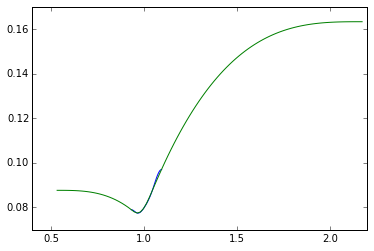

In [16]:
"""
Author: Weiyi Chen
Copyright: Copyright (C) 2015 Baruch College, Modeling and Market Making in FX - All Rights Reserved
Description: Test for VolSpliner
"""

from volspliner import VolSpliner
from scipy import *
import scipy.stats as stats
import matplotlib.pyplot as plot

def test():
    '''Test with VolSpliner'''
    
    for extrap_fact in [0.01,10]:
        
        # generate the spline and change the extrapolation factor
        
        sp = VolSpliner()
        sp.Extrap_fact = extrap_fact
        
        nstrikes   = 100
        dstrike    = (sp.StrikeMax-sp.StrikeMin)/(nstrikes-1)
        
        plot_strikes, plot_vols = [], []
        for i in range(nstrikes):
            strike = sp.StrikeMin + i * dstrike
            plot_strikes.append(strike)
            plot_vols.append(sp.volatility(strike))
        plot.plot(plot_strikes,plot_vols)
    plot.show()

if __name__=="__main__":
    test()


##### Intuition

Green line corresponds to extrapolation factor $10$, and blue corresponds $0.1$.

- The values of volatility at common range are similar with different extrapolation factors.
- With larger extrapolation factor, the speed of the slope converge to zero becomes lower, therefore it has a larger range of strikes (with slope not equal to zero)